# Using Images from HEASARC

In this notebook, we show how to search for and retrieve images from the HEASARC's holdings.

* [1. Finding](#finding) HEASARC SIA resources from the NAVO directory with TAP
* [2. Using](#sia) SIA to retrieve an image from SkyView


In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import requests, io, astropy
from IPython.display import Image, display

## For handling ordinary astropy Tables
from astropy.table import Table

## For reading FITS files
import astropy.io.fits as apfits

## For pretty displays
import aplpy

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

<a id="finding"></a>

# 1.  Finding HEASARC SIA resources from the NAVO directory with TAP

The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the __[Simple Image Access](http://www.ivoa.net/documents/SIA/)__ (SIA) protocol. But first, how do you know what sorts of images are available?

First, we can find out what SIA resources are available through SkyView. These are listed in a registry at STScI which we can access through the __[Table Access Protocol](http://www.ivoa.net/documents/TAP/)__ (TAP). The TAP protocol is described in detail in its own notebook.  Here, we submit an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what we wish to search for, in this case the HEASARC SIA resources.

(The properties we want, the short name, the description, and the URL, are each in different parts of the registry.  See the __[RegTAP](http://www.ivoa.net/documents/RegTAP/)__ documentation.)  

<div class="alert alert-block alert-danger">
This should in future be implemented as a function, e.g.,<br>
    results=astroquery.heasarc.query_sia_services()<br>
If the results includes the URL, then the user need no know whether the image is from Xamin or SkyView, unless the description talks about it.  
</div>

In [2]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,b.res_description, c.access_url 
        from rr.capability a natural join rr.resource b natural join rr.interface c
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
## The astropy.table  module will read this VO Table formatted result into an astropy Table:
cat_table=Table.read(io.BytesIO(r.content))
#print(r.content)
## Just look at some non-so-randomly selected rows out of the 108 returned:
cat_table[85:96]
## Note that some of the other rows have special characters that confuse the print functions and cause errors.

short_name,res_description,access_url
object,object,object
SDSS,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive (currently release DR9) to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdss&amp;
SDSSDR7,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdssdr7&amp;
SFD,"The full sky 100 micron map is a reprocessed composite of the COBE/DIRBE and IRAS/ISSA maps, with the zodiacal foreground and confirmed point sources removed. Artifacts from the IRAS scan pattern were removed. The result of these manipulations is a map with DIRBE-quality calibration and IR AS resolution.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sfd&amp;
SHASSA,"The Sshassa\.xml\.outhern H-Alpha Sky Survey Atlas is the product of a wide-angle digital imaging survey of the H-alpha emission from the warm ionized interstellar gas of our Galaxy. This atlas covers the sshassa\.xml\.outhern hemisphere sky (declinations less than +15 degrees). The observations were taken with a robotic camera operating at Cerro Tololo Inter-American Observatory (CTIO) in Chile. The atlas consists of 2168 images covering 542 fields. There are four images available for each field: &amp;lt;b&amp;gt;H-alpha&amp;lt;/b&amp;gt;, &amp;lt;b&amp;gt;Continuum&amp;lt;/b&amp;gt;, &amp;lt;b&amp;gt;Continuum-Corrected&amp;lt;/b&amp;gt; (the difference of the H-alpha and Continuum images), and &amp;lt;b&amp;gt;Smoothed&amp;lt;/b&amp;gt; (median filtered to 5 pixel, or 4.0 arcminute, resolution to remove star residuals better). The &amp;lt;a href=""http://amundsen.swarthmore.edu/SHASSA""&amp;gt;SHASSA web site&amp;lt;/a&amp;gt; has more details of the data and the status of this and related projects. Images can also be obtained from the &amp;lt;a href=""http://amundsen.astro.swarthmore.edu/SHASSA/#Images""&amp;gt;Download Images&amp;lt;/a&amp;gt; section at the SHASSA site.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=shassa&amp;
SkyView,"SkyView is a Virtual Observatory on the Net. Astronomers can generate images of any portion of the sky at wavelengths in all regimes from radio to gamma-ray. Users tell SkyView the position, scale and orientation desired, and SkyView gives users an image made to their specification. The user need not worry about transforming between equinoxes or coordinate systesm, mosaicking submaps, rotating the image,.... SkyView handles these geometric issues and lets the user get started on astronomy.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?
Stripe82VLA,"This survey is a deep, high resolution radio survey of a relatively small region that has particularly deep coverage in the Sloan Digital Sky Survey. As described in the reference abstract: This is a high-resolution radio survey of the Sloan Digital Sky Survey (SDSS) Southern Equatorial Stripe, a.k.a., Stripe 82. This 1.4 GHz survey was conducted from 2007 to 2009 with the Very Large Array primarily in the A-configuration, with supplemental B-configuration data to increase sensitivity to extended structure. The survey has an angular resolution of 1.8"" and achieves a median rms noise of 53 microJy/beam over 92 square degrees. This is the deepest 1.4 GHz survey to achieve this large of an area filling in the phase space between small&amp;amp;amp;deep and large&amp;amp;amp;shallow surveys. &amp;lt;p&amp;gt; Th

We can then specify the service we want by using the "access_url" entry in the row corresponding to the service we want.  The above is printing a subset of the rows, and below we'll use the row numbers that you can figure out from that. 

<a id="sia"></a>

# 2. Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, the Swift UVOT from *SkyView* (note not the Xamin service;  see below), and look for images of our favorite source.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you specify the central position, POS, the angular SIZE, and the NAXIS, i.e., the number of bins.  (SkyView will bin/interpolate as needed from the archive data.)  

<div class="alert alert-block alert-danger">
This needs to be updated once the registry has the SkyView entries for Swift UVOT.  For now, just use the URL we know works.  But once RegTAP updated, take the URL from the above query.
</div>

In [3]:
## This is sometimes inaccessible
#import astropy.coordinates as coord
#coord=coord.SkyCoord.from_name("m51")
#pos='{},{}'.format(coord.ra.deg,coord.dec.deg)
pos='202.469575,47.195258'
#pos='148.619188,-25.703436' # NGC 3054
params = {'POS': pos, 'SIZE':'0.2', "NAXIS":"300,300"}
#params = {'survey': 'sdss', 'POS': pos, 'SIZE':'0.1', "NAXIS":"300,300"}
#r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
r = requests.get(cat_table[-14]['access_url'], params=params)
uvot_table=Table.read(io.BytesIO(r.content))
uvot_table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
swiftuvotvint,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161989477&return=FITS,1
swiftuvotvint,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161989477&nofits=1&quicklook=jpeg&return=jpeg,1
swiftuvotbint,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161989768&return=FITS,2
swiftuvotbint,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161989768&nofits=1&quicklook=jpeg&return=jpeg,2
swiftuvotuint,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161990999&return=FITS,3
swiftuvotuint,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161990999&nofits=1&quicklook=jpeg&return=jpeg,3
swiftuvotuvw1int,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161991475&return=FITS,4
swiftuvotuvw1int,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161991475&nofits=1&quicklook=jpeg&return=jpeg,4
swiftuvotuvw2int,202.46957499999999,47.195258000000003,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161991986&return=FITS,5


<div class="alert alert-block alert-danger">
This should be a function, e.g.,<br>
astroquery.heasarc.query_skyview()
</div>

Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [4]:
rowf=6 # You see above that even-numbered rows are the JPEGs, the next the corresponding FITS
rowj=rowf+1
###  Inside the table is a numpy record array that you can access like this, for example:
#print(table.array[7][8])
#  Or like this
print(uvot_table[rowf]['URL'])
### To download the FITS image itself:
print(uvot_table[rowj]['URL'])

https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161991475&return=FITS
https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.195258&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1515161991475&nofits=1&quicklook=jpeg&return=jpeg


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


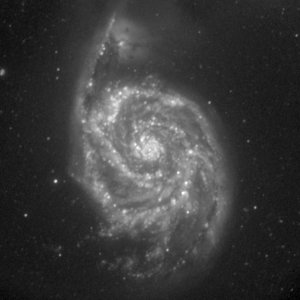

In [5]:
##  Note that there are bugs with some of these datasets, 
##  since they are new in SkyView.  Selecting the UVW1-band image.
##  (The decode is needed in Python 3.5 because it comes back a byte type.)
##  Handing Image(url="http....") to display doesn't always work for reasons unknown.  Download it first.
##  And because urllib is hard to make Python 2/3 compatible, just use requests:
r=requests.get(uvot_table['URL'][rowj].decode("utf-8"), stream=True)
with open('my_image.jpeg','wb') as f:
    f.write(r.content)
display(Image("my_image.jpeg"))

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

In [6]:
## Download the FITS image?
r=requests.get(uvot_table['URL'][rowf].decode("utf-8"), stream=True)
with open('my_image.fits','wb') as f:
    f.write(r.content)

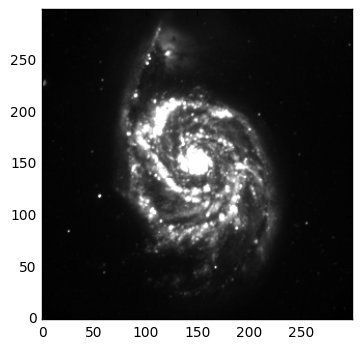

In [7]:
#hdu_list=apfits.open(uvot_table['URL'][4].decode("utf-8"))
hdu_list=apfits.open('my_image.fits')
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.02)

<div class="alert alert-block alert-danger">
Why does it so frequently time out when handing the URL to apfits.open()?
</div>

### Now with aplpy

INFO: Auto-setting vmin to  5.427e-04 [aplpy.core]


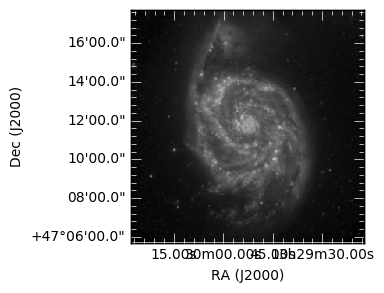

In [8]:
gc = aplpy.FITSFigure(hdu_list,figsize=(3, 3))
gc.show_grayscale(stretch='log', vmax=1.)

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  In this case, the user is unaware of where the data come from, which is the point.  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it will take a few seconds for the image to appear.)

In [9]:
## We could go back to our TAP query results to find the SDSS URL.  
#params['survey']='sdssg'
#r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
r = requests.get(cat_table[-23]['access_url'], params=params)
sdss_table=Table.read(io.BytesIO(r.content))
#print(r.content)

In [10]:
r=requests.get(sdss_table['URL'][0].decode("utf-8"), stream=True)
with open('my_image2.fits','wb') as f:
    f.write(r.content)

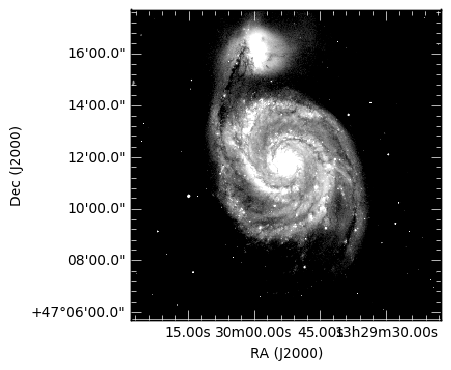

In [11]:
hdu_list=apfits.open('my_image2.fits')
gc = aplpy.FITSFigure(hdu_list,figsize=(4,4))
gc.show_grayscale(stretch='log', vmin=0.1,vmax=1.)


# 3. Retrieving a 'raw' image from Xamin
The SkyView service is a flexible and powerful way to view any sized region of the sky and to compare among different telescopes.  The results, however, are smoothed, interpolated and mosaic'd in a way that makes the scientific interpretation more complicated.  If you wish to retrieve the original observation data, these are listed in HEASARC's __[Xamin](https://heasarc.gsfc.nasa.gov/xamin/)__ service, which also provides an SIA interface.

Above, we used the TAP to query the registry of SIA services and selected a Swift UVOT image from SkyView.  But we could instead use the Xamin query for the original observation images.

<div class="alert alert-block alert-danger">
To be fixed:  the dev server has a version that astropy.table can read.  But pprint() still doesn't work for it.
</div>

In [12]:
params = {'survey': 'swiftuvot', 'POS': pos}
r = requests.get(cat_table[-13]['access_url'], params=params)
uvot_raw_table=Table.read(io.BytesIO(r.content))
# the pretty print is broken on this result.  Get one random row:
print(uvot_raw_table['SIA_reference'][10])

https://heasarc.gsfc.nasa.gov/xamin/vo/extract?file=/FTP/swift/data/obs/2011_06/00032017038/uvot/image/sw00032017038uvv_sk.img.gz&extension=vv330063068I


In [13]:
r=requests.get(uvot_raw_table['SIA_reference'][10].decode("utf-8"), stream=True)
with open('my_image3.fits','wb') as f:
    f.write(r.content)

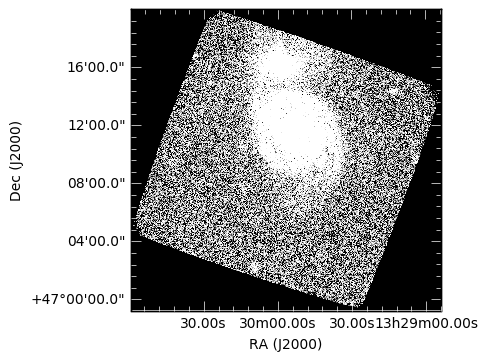

In [14]:
hdu_list=apfits.open('my_image3.fits')
gc = aplpy.FITSFigure(hdu_list,figsize=(4,4))
gc.show_grayscale(stretch='log', vmin=0.1,vmax=1.)
